# **TRAINING MODEL**

## **LOADING DATA**

In [2]:
# Import dataset

file_score = "../DATAS/CleanALL_EHCVM_ML.csv"

## **IMPORTS LIBRARIES**

In [3]:
# Imports Libairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import joblib

import warnings

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV 


In [4]:
# Import Mod√®les

from sklearn.svm import SVC

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

## **READ DATA**

In [34]:
df_score = pd.read_csv(file_score)
C_df_score = df_score.copy()
C_df_score

mstat  rev_total_mois age_grp  empl_formel  bancarise  \
0      C√©libataire        279244.0   25-34            1          1   
1      C√©libataire             0.0    0-17            0          0   
2      C√©libataire             0.0    0-17            0          0   
3      C√©libataire             0.0    0-17            0          0   
4         Mari√©(e)             0.0   25-34            0          0   
...            ...             ...     ...          ...        ...   
64469  C√©libataire             0.0    0-17            0          0   
64470  C√©libataire             0.0    0-17            0          0   
64471  C√©libataire             0.0    0-17            0          0   
64472  C√©libataire             0.0    0-17            0          0   
64473     Mari√©(e)             0.0   35-44            0          1   

       a_assurance               logem  
0                0           Locataire  
1                0           Locataire  
2                0           Locataire  
3                0           Locataire  
4                0           Locataire  
...            ...                 ...  
64469            0  Proprietaire titre  
64470            0  Proprietaire titre  
64471            0  Proprietaire titre  
64472            0  Proprietaire titre  
64473            0  Proprietaire titre  

[64474 rows x 7 columns]

## **COURBE KDE (Kernel Density Estimator) : Approximation of the probability density of each variable**

Differentes cat√©gories


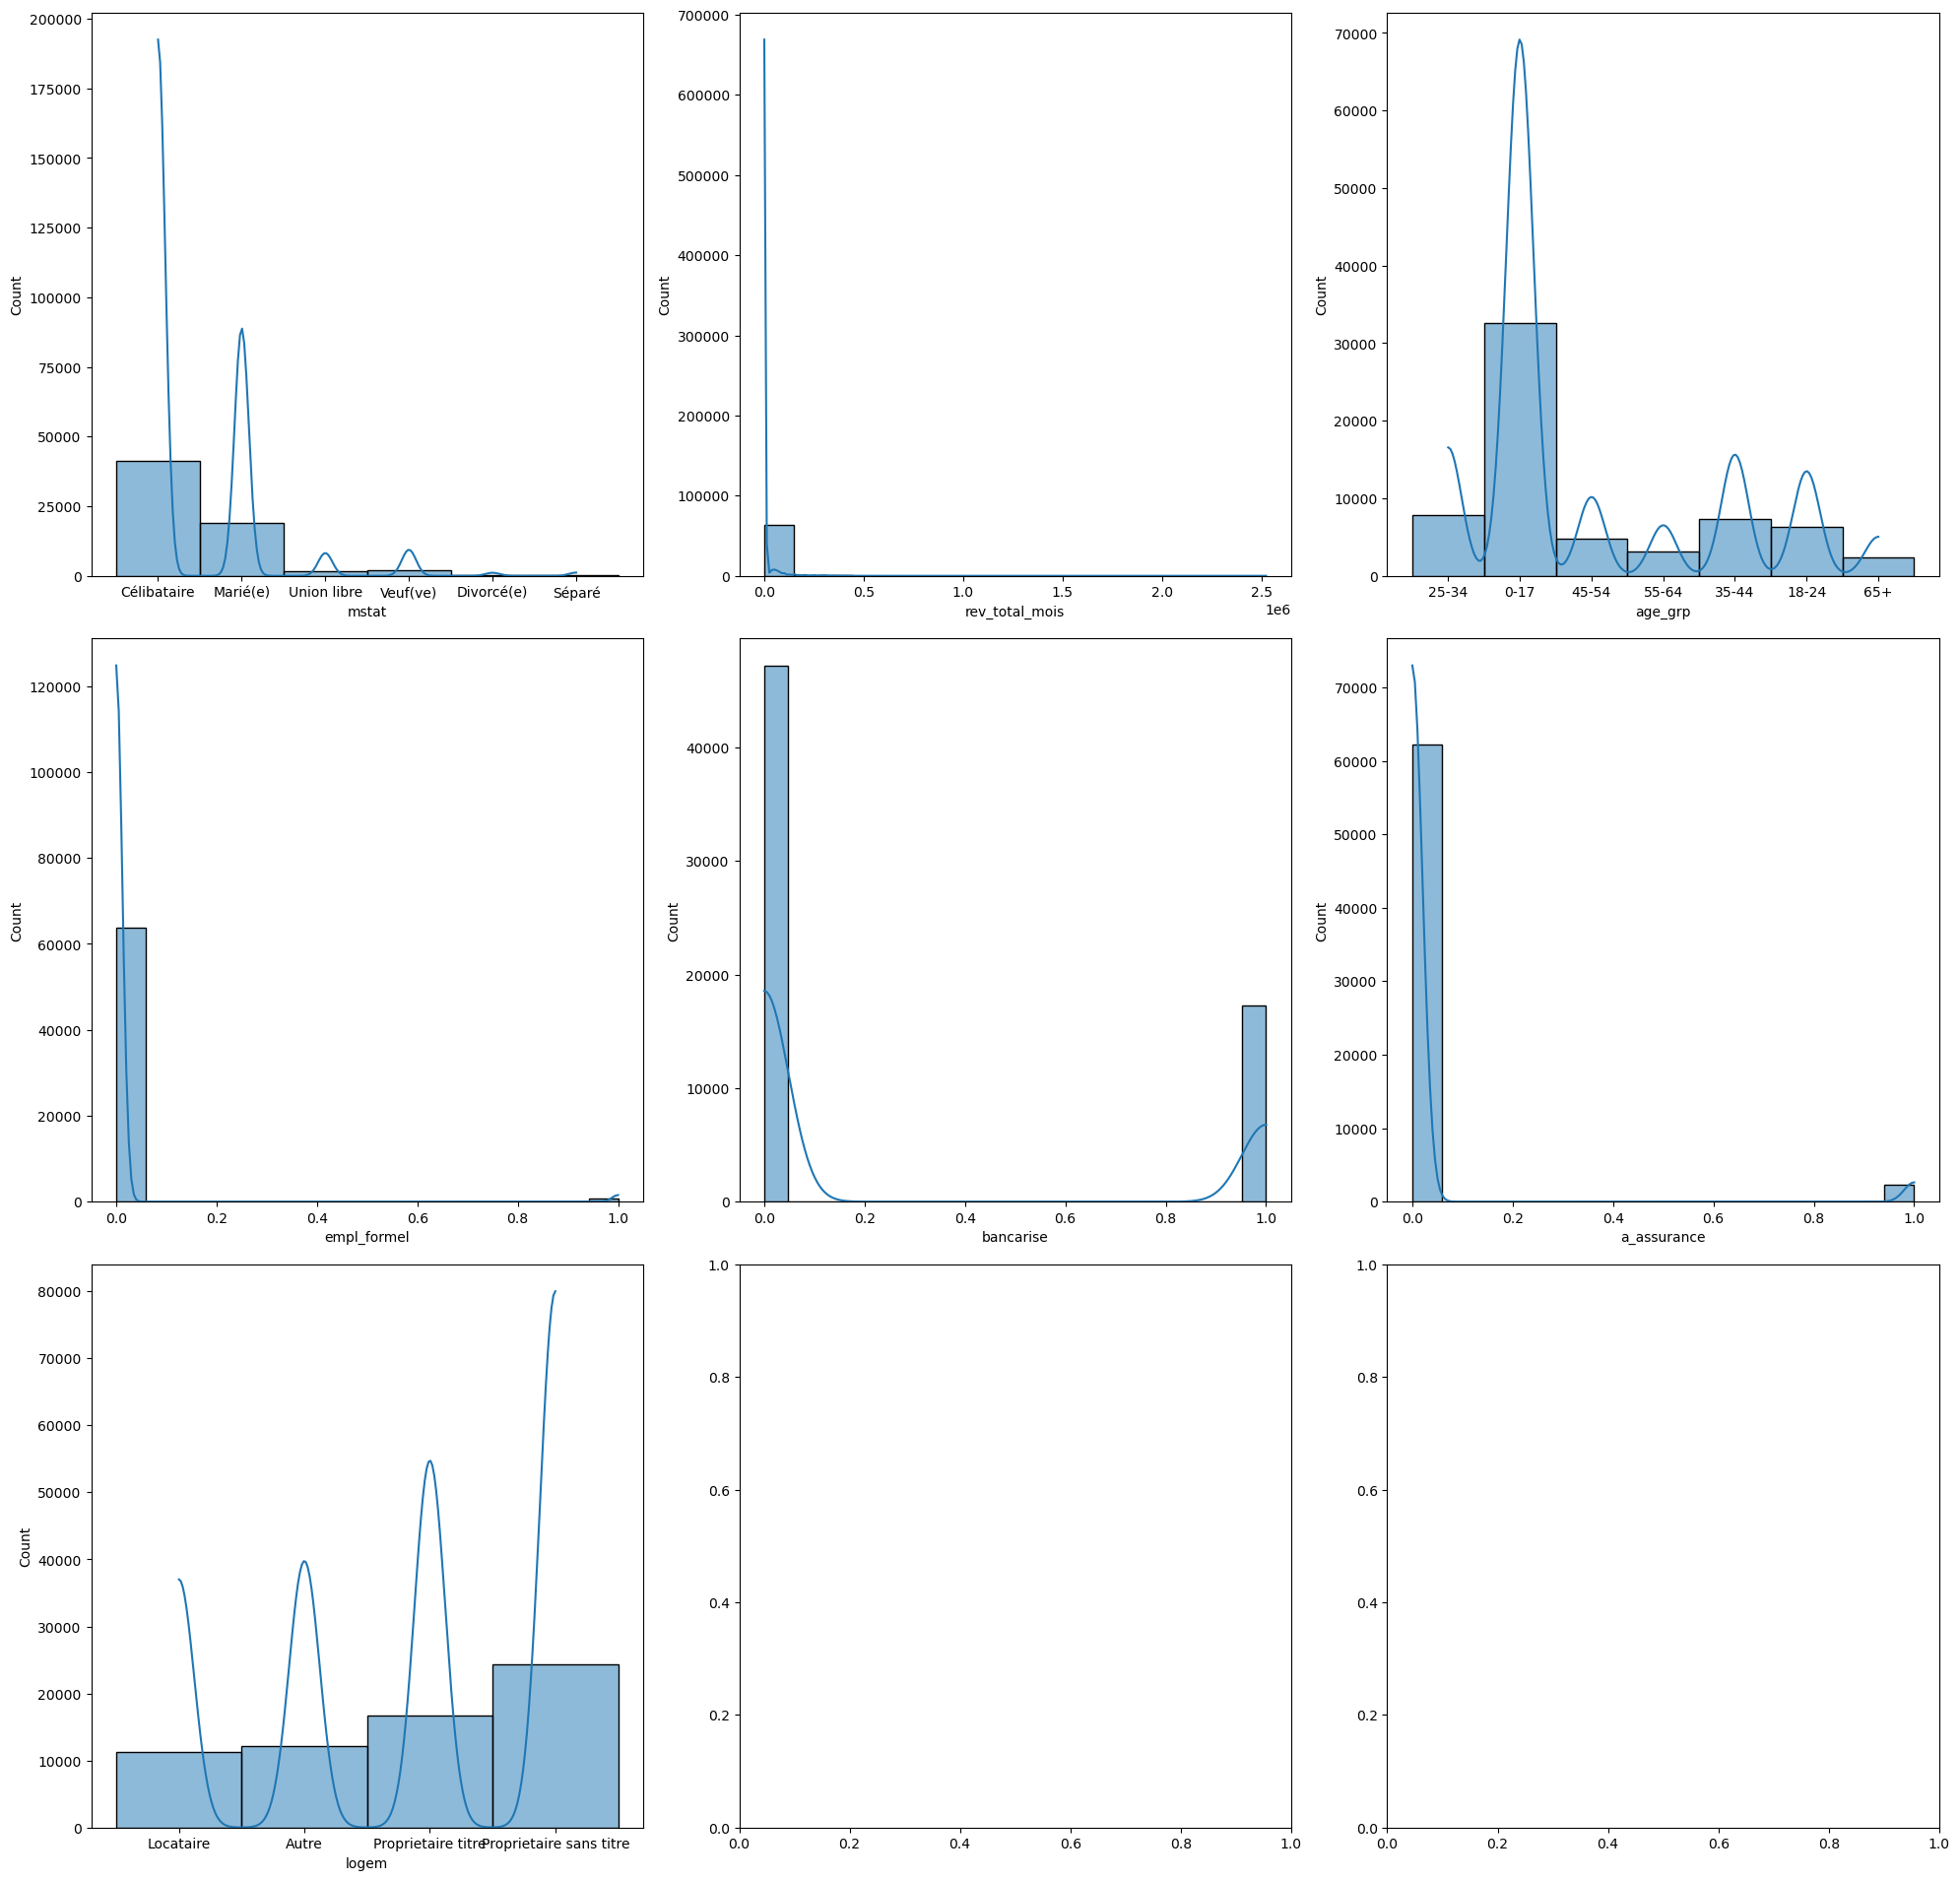

In [40]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax = ax.flatten()
i = 0
C_df_score.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in C_df_score.columns:
    sns.histplot(data = C_df_score, x=col,kde = True ,ax = ax[i])
    i += 1
plt.tight_layout(rect=[0, 0, 1, 0.96])
print("Differentes cat√©gories")
plt.show()

**INTEPRETATIONS DES GRAPHS :** 

**mstat (Situation matrimoniale)**

    La variable montre une majorit√© d'individus c√©libataires et mari√©s, avec beaucoup moins d'unions libres, veufs, divorc√©s ou s√©par√©s. La distribution est tr√®s d√©s√©quilibr√©e, refl√©tant probablement la structure habituelle de la population adulte dans l'√©chantillon.

**rev_total_mois (Revenu total mensuel)**

    La r√©partition du revenu est tr√®s asym√©trique √† droite : la plupart des individus ont des revenus faibles, avec une toute petite proportion ayant des revenus tr√®s √©lev√©s. Cela sugg√®re une forte in√©galit√© √©conomique ou sociale dans la population analys√©e.

**age_grp (Groupe d'√¢ge)**

    On observe une concentration importante dans certains groupes d'√¢ge (‚Äú0-17‚Äù, ‚Äú25-34‚Äù) et moins de personnes dans les classes plus √¢g√©es (‚Äú65+‚Äù). Cette distribution est typique d‚Äôune population jeune.

**empl_formel (Emploi formel)**

    La majorit√© des individus n'ont pas d'emploi formel (valeur proche de z√©ro majoritaire). Cela traduit une forte pr√©valence de l‚Äôinformel dans l‚Äôemploi.

**bancarise (Bancarisation)**

    On distingue deux pics distincts (0 et 1) : une part significative de la population n‚Äôa pas acc√®s √† la bancarisation. Cela confirme une faible inclusion financi√®re ‚Äúofficielle‚Äù dans l‚Äô√©chantillon.

**a_assurance (Acc√®s √† une assurance maladie)**

    La tendance est similaire √† la bancarisation : tr√®s peu de personnes disposent d'une assurance. La couverture reste tr√®s marginale.

**logem (Statut logement)**

    La distribution est l√©g√®rement in√©gale, avec une pr√©f√©rence claire pour certains statuts (propri√©taire sans titre et locataire dominant), ce qui refl√®te les situations courantes de logement.

**Profil_Score (Score d‚Äôinclusion financi√®re)**

    La variable se concentre autour de certains scores typiques, avec des pics r√©p√©t√©s : cela refl√®te la segmentation introduite par tes r√®gles de scoring. On note une diversit√© mais une polarisation sur quelques profils dominants.

**OBSERVATION**
    
**Ces observations faites des tendances de la population ont un impact sur les crit√®res du profil.**

## **CREATION OF THE TARGET**

In [35]:

def score_inclusion_financiere(row):
    score = 0
       
    #print(f"\n---------------------Data {row.name}------------------\n")

    # Situation Matrimoniale (20 points)
    if row['mstat'] in ["Mari√©(e)", "Union libre"]:
        score += 20
    elif row['mstat'] in ["C√©libataire", "Divorc√©(e)", "S√©par√©"]:
        score += 8
    elif row['mstat'] == "Veuf(ve)":
        score += 10
    
    #print(f"1 - {score}")
    
    # Groupe d'√Çge (10 points)
    if row['age_grp'] in ["18-24", "65+"]:
        score += 5
    elif row['age_grp'] in ["35-44", "45-54"]:
        score += 10
    elif row['age_grp'] in ["25-34", "55-64"]:
        score += 7
    
    #print(f"2 - {score}")
    
    # Bancarisation (15 points)
    if row['bancarise'] == 1:
        score += 15
    elif row['bancarise'] == 0:
        score += 8

    #print(f"3 - {score}")
    
    # Assurance (5 points)
    if row['a_assurance'] == 1:
        score += 5
    elif row['a_assurance'] == 0:
        score += 2

    #print(f"4 - {score}")
    
    # Emploi formel (5 points)
    if row['empl_formel'] == 1:
        score += 5
    elif row['empl_formel'] == 0:
        score += 2

    #print(f"5 - {score}")

    # Logement (20 points)
    if row['logem'] in ["Proprietaire sans titre", "Proprietaire titre"]:
        score += 20
    elif row['logem'] == "Locataire":
        score += 10

    #print(f"6 - {score}")

    # Revenu (25 points)
    if (row['rev_total_mois'] >= 50000) and (row['rev_total_mois'] < 300000):
        score += 5
    elif (row['rev_total_mois'] >= 300000) and (row['rev_total_mois'] < 500000):
        score += 10
    elif (row['rev_total_mois'] >= 500000) and (row['rev_total_mois'] < 1000000):
        score += 20
    elif row['rev_total_mois'] >= 1000000:
        score += 25

    #print(f"7 - {score}")
    #print(f"\n---------------------------------------\n")

    return score


In [36]:
C_df_score['Profil_Score'] = C_df_score.apply(score_inclusion_financiere, axis=1)
print("-------------- FIN DE LA CREATION DU TARGET --------------")

-------------- FIN DE LA CREATION DU TARGET --------------


In [37]:
classes = C_df_score['Profil_Score'].unique()
classes

array([ 52,  30,  49,  59,  56,  42,  44,  47,  37,  33,  45,  75,  70,
        62,  20,  34,  27,  65,  35,  23,  25,  32,  60,  57,  50,  55,
        64,  54,  40,  71,  74,  39,  46,  61,  68,  69,  43,  66,  85,
        77,  67,  38,  72,  51,  36,  63,  82,  88,  92,  73,  87,  48,
        94,  95, 100,  80,  79,  89,  90,  83,  84,  53,  28,  58,  76,
        41,  29])

In [38]:
C_df_score['Profil_Score'].nunique()

67

## **LABELING OF VARIABLES**

In [18]:
label_encoders = {}

# Variables cat√©gorielles √† encoder
cat_cols = ['mstat', 'age_grp', 'logem']

for col in cat_cols:
    le = LabelEncoder()
    C_df_score[col] = le.fit_transform(C_df_score[col])
    label_encoders[col] = le
C_df_score

mstat  rev_total_mois  age_grp  empl_formel  bancarise  a_assurance  \
0          0        279244.0        2            1          1            0   
1          0             0.0        0            0          0            0   
2          0             0.0        0            0          0            0   
3          0             0.0        0            0          0            0   
4          2             0.0        2            0          0            0   
...      ...             ...      ...          ...        ...          ...   
64469      0             0.0        0            0          0            0   
64470      0             0.0        0            0          0            0   
64471      0             0.0        0            0          0            0   
64472      0             0.0        0            0          0            0   
64473      2             0.0        3            0          1            0   

       logem  Profil_Score  
0          1            52  
1          1            30  
2          1            30  
3          1            30  
4          1            49  
...      ...           ...  
64469      3            40  
64470      3            40  
64471      3            40  
64472      3            40  
64473      3            69  

[64474 rows x 8 columns]

In [19]:
# Afficher les mappings pour chaque variable
for col in cat_cols:
    le = label_encoders[col]
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Mapping '{col}':")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")
    print("-" * 30)

Mapping 'mstat':
  C√©libataire -> 0
  Divorc√©(e) -> 1
  Mari√©(e) -> 2
  S√©par√© -> 3
  Union libre -> 4
  Veuf(ve) -> 5
------------------------------
Mapping 'age_grp':
  0-17 -> 0
  18-24 -> 1
  25-34 -> 2
  35-44 -> 3
  45-54 -> 4
  55-64 -> 5
  65+ -> 6
------------------------------
Mapping 'logem':
  Autre -> 0
  Locataire -> 1
  Proprietaire sans titre -> 2
  Proprietaire titre -> 3
------------------------------


In [20]:
C_df_score

mstat  rev_total_mois  age_grp  empl_formel  bancarise  a_assurance  \
0          0        279244.0        2            1          1            0   
1          0             0.0        0            0          0            0   
2          0             0.0        0            0          0            0   
3          0             0.0        0            0          0            0   
4          2             0.0        2            0          0            0   
...      ...             ...      ...          ...        ...          ...   
64469      0             0.0        0            0          0            0   
64470      0             0.0        0            0          0            0   
64471      0             0.0        0            0          0            0   
64472      0             0.0        0            0          0            0   
64473      2             0.0        3            0          1            0   

       logem  Profil_Score  
0          1            52  
1          1            30  
2          1            30  
3          1            30  
4          1            49  
...      ...           ...  
64469      3            40  
64470      3            40  
64471      3            40  
64472      3            40  
64473      3            69  

[64474 rows x 8 columns]

### **Correlation Matrix**

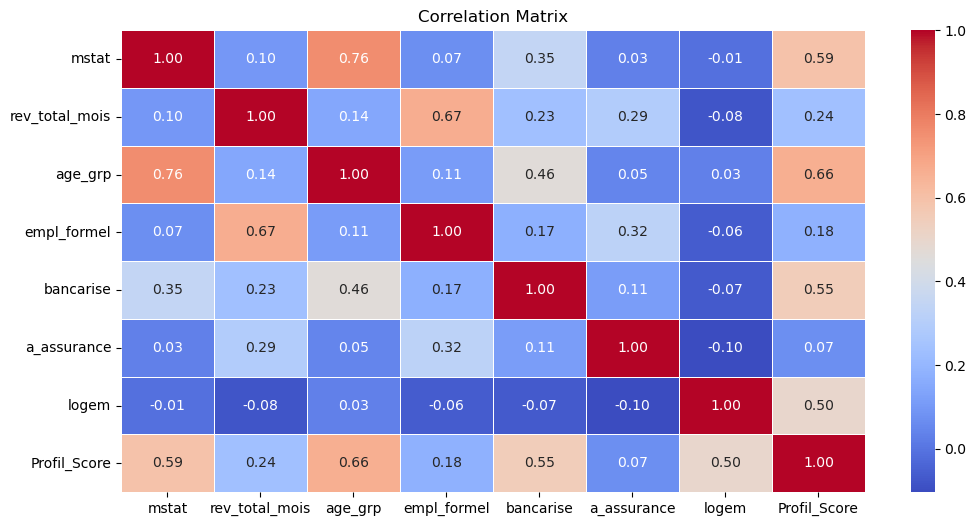

In [21]:
df_subset = C_df_score
corr_matrix = df_subset.corr()
plt.figure(figsize = (12,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Les m√©thodes de filtrage comme la corr√©lation ou le seuil de variance sont excellentes quand nous avons beaucoup de caract√©ristiques et voulons supprimer rapidement celles qui ne sont pas pertinentes et voir le comportement des caract√©risques par rapport √† la variable cible. Cependant, si nous voulons maximiser les performances du mod√®le et avoir les ressources de calcul, nous pourrions vouloir explorer des m√©thodes d'emballage comme RFE ou des m√©thodes int√©gr√©es comme Lasso. 

#### La matrice de correlation permet aussi d'observer les variables qui sont corr√©l√©es entre elles et celles qui ont un impact sur la variable cible. Ainsi l'on √† une id√©e de comment maximiser les performances du mod√®le et optimiser √† l'avance les erreurs possibles du mod√®le.

#### OBSERVATION : Les variables ne sont pas corr√©l√©es entre elles et √† la variable cible. Pas de probl√®me √† ce niveau. 

## **SEPARATE THE FEATURES FROM THE TARGET**

In [22]:
# Separation des caract√©risques et de la cible

X = C_df_score.drop(columns=['Profil_Score'])
y = C_df_score['Profil_Score']

In [23]:
X

mstat  rev_total_mois  age_grp  empl_formel  bancarise  a_assurance  \
0          0        279244.0        2            1          1            0   
1          0             0.0        0            0          0            0   
2          0             0.0        0            0          0            0   
3          0             0.0        0            0          0            0   
4          2             0.0        2            0          0            0   
...      ...             ...      ...          ...        ...          ...   
64469      0             0.0        0            0          0            0   
64470      0             0.0        0            0          0            0   
64471      0             0.0        0            0          0            0   
64472      0             0.0        0            0          0            0   
64473      2             0.0        3            0          1            0   

       logem  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
64469      3  
64470      3  
64471      3  
64472      3  
64473      3  

[64474 rows x 7 columns]

In [24]:
y

0        52
1        30
2        30
3        30
4        49
         ..
64469    40
64470    40
64471    40
64472    40
64473    69
Name: Profil_Score, Length: 64474, dtype: int64

## **STANDARDIZATION OF VARIABLES**

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
X_scaled

array([[-0.67203399,  5.59637273,  0.3093478 , ...,  1.65510041,
        -0.18989412, -0.67477797],
       [-0.67203399, -0.18247058, -0.8007677 , ..., -0.60419295,
        -0.18989412, -0.67477797],
       [-0.67203399, -0.18247058, -0.8007677 , ..., -0.60419295,
        -0.18989412, -0.67477797],
       ...,
       [-0.67203399, -0.18247058, -0.8007677 , ..., -0.60419295,
        -0.18989412,  1.23177511],
       [-0.67203399, -0.18247058, -0.8007677 , ..., -0.60419295,
        -0.18989412,  1.23177511],
       [ 0.8735435 , -0.18247058,  0.86440555, ...,  1.65510041,
        -0.18989412,  1.23177511]])

## **SEPARATION OF TRAINING AND TESTING**

In [27]:
features = ['mstat', 'age_grp', 'bancarise', 'a_assurance', 'empl_formel', 'logem', 'rev_total_mois']
target = 'Profil_Score'

In [28]:
# Donn√©es d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=40)
print(f"X_train :{X_train.shape}")
print(f"y_train :{y_train.shape}")
print(f"X_test :{X_test.shape}")
print(f"y_test :{y_test.shape}")

X_train :(51579, 7)
y_train :(51579,)
X_test :(12895, 7)
y_test :(12895,)


In [29]:
X_train

array([[ 0.8735435 , -0.18247058,  1.4194633 , ..., -0.60419295,
        -0.18989412,  0.27849857],
       [-0.67203399, -0.18247058, -0.8007677 , ..., -0.60419295,
        -0.18989412, -0.67477797],
       [-0.67203399, -0.18247058, -0.8007677 , ..., -0.60419295,
        -0.18989412,  0.27849857],
       ...,
       [ 0.8735435 , -0.18247058,  0.3093478 , ...,  1.65510041,
        -0.18989412, -0.67477797],
       [-0.67203399, -0.18247058, -0.8007677 , ..., -0.60419295,
        -0.18989412,  0.27849857],
       [-0.67203399, -0.18247058, -0.8007677 , ..., -0.60419295,
        -0.18989412,  1.23177511]])

## **MODEL TRAINING PROCESS**

### **Choice The Best Model**

In [116]:
models = {
    "Random Classifier": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    "Random Regressor" : RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    "Support Vector Machine": SVC(),
}

results = {}

In [117]:
for name, model in models.items():
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test) 
    joblib.dump(model, f'{name}.joblib')

    print(f"\nüèÜ {name}\n")
    
    if "Classifier" in name or "Support Vector Machine" in name:
        acc = accuracy_score(y_test, y_pred)
        pres = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        print(f"          - Accuracy: {acc:.4f}")
        print(f"          - Pression score: {pres:.4f}")
        print(f"          - Recall score: {rec:.4f}\n")
        print(classification_report(y_test, y_pred))

        results[name] = acc 
    else:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"          - R2 score: {r2:.4f}")
        print(f"          - RMSE: {rmse:.4f}\n")

        results[name] = r2 

    # Analyse d'importance des variables
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({'variable': features, 'importance': importances}).sort_values(by='importance', ascending=False)
        print("          Importance des variables :\n", importance_df)


üèÜ Random Classifier

          - Accuracy: 0.9898
          - Pression score: 0.9895
          - Recall score: 0.9898

              precision    recall  f1-score   support

          20       1.00      1.00      1.00      1134
          23       1.00      1.00      1.00        39
          25       1.00      0.97      0.99        69
          27       1.00      0.99      0.99        75
          28       1.00      1.00      1.00         4
          29       1.00      1.00      1.00        19
          30       1.00      1.00      1.00       953
          32       0.98      0.97      0.97        88
          33       1.00      1.00      1.00        97
          34       0.97      0.95      0.96        65
          35       1.00      0.96      0.98       111
          36       1.00      1.00      1.00         7
          37       1.00      0.96      0.98       204
          38       1.00      1.00      1.00         3
          39       0.99      0.99      0.99       150
          40

### **Vizualisation Models**

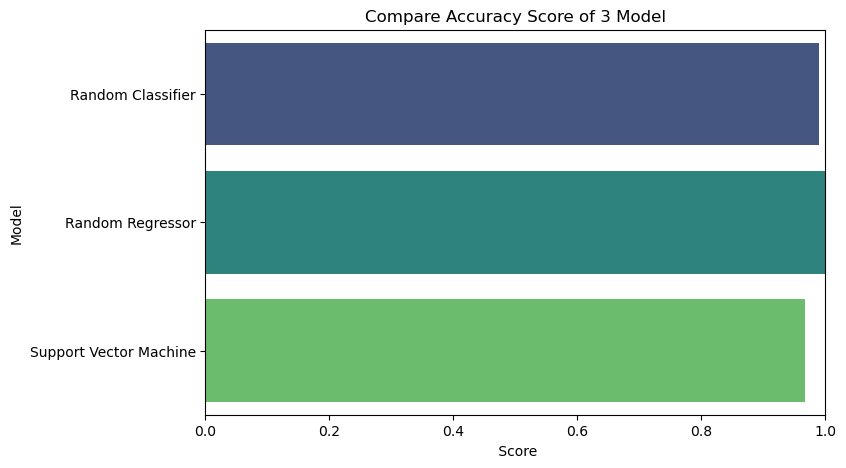

In [118]:
results_df = pd.DataFrame(results.items(), columns=["Model", "Score"])
plt.figure(figsize=(8, 5))
sns.barplot(x="Score", y="Model", data=results_df, palette="viridis")
plt.xlabel(" Score")
plt.ylabel("Model")
plt.title("Compare Accuracy Score of 3 Model")
plt.xlim(0, 1)
plt.show()

### **Search for the Hyperparameter of the Best Model**

In [119]:
rf = RandomForestRegressor(random_state=42)

# Grille d'hyperparam√®tres
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

**GridSearchCV with RMSE**

In [135]:
# GridSearchCV avec RMSE comme m√©tric
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,         # 5-fold cross validation
    scoring='neg_root_mean_squared_error', # RMSE
    n_jobs=-1,
    verbose=0
)

# Entra√Ænement sur le train set
grid_search.fit(X_train, y_train)

print("Meilleurs param√®tres :", grid_search.best_params_)

Meilleurs param√®tres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [163]:
results = grid_search.cv_results_

# Pour la meilleure combinaison d'hyperparam√®tres :
best_idx = grid_search.best_index_
mean_rmse = -results['mean_test_score'][best_idx]  # n√©gatif car scoring='neg_root_mean_squared_error'
std_rmse = results['std_test_score'][best_idx]

print(f"RMSE moyen (CV): {mean_rmse:.2f} ¬± {std_rmse:.2f}")

RMSE moyen (CV): 0.33 ¬± 0.05


**GridSearchCV with R2**

In [166]:
# GridSearchCV avec R2 comme m√©tric
grid_search_r2 = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)
grid_search_r2.fit(X_train, y_train)
results_r2 = grid_search_r2.cv_results_
best_idx_r2 = grid_search_r2.best_index_
mean_r2 = results_r2['mean_test_score'][best_idx_r2]
std_r2 = results_r2['std_test_score'][best_idx_r2]

print("Meilleurs param√®tres :", grid_search_r2.best_params_)
print(f"R¬≤ moyen (CV): {mean_r2:.3f} ¬± {std_r2:.3f}")

Meilleurs param√®tres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R¬≤ moyen (CV): 0.999 ¬± 0.000


**Principes de recherches des hypers param√®tres**

**estimator=rf**

        Mod√®le de base que tu souhaites entra√Æner et optimiser, ici un Random Forest Regressor
**param_grid=param_grid**

    Un dictionnaire contenant les hyperparam√®tres et leurs diff√©rentes valeurs possibles.
    GridSearchCV essaiera toutes les combinaisons possibles list√©es pour trouver la meilleure
**cv=5**

    Le nombre de folds dans la validation crois√©e.Ici, le dataset est divis√© en 5 parties diff√©rentes.
    4 parts servent √† l'entra√Ænement, 1 √† la validation, et ce, 5 fois en changeant la partie de validation.
**scoring='neg_root_mean_squared_error'**
    
    RMSE : La m√©trique utilis√©e pour √©valuer la performance du mod√®le
**n_jobs=-1**
    
    Utilisation de tous les c≈ìurs CPU disponibles pour parall√©liser le calcul
**verbose**
    
    Contr√¥le le niveau de verbosit√© (affichage d'informations pendant l'ex√©cution) 
    0 = Aucunes infos
    2 = Infos d√©taill√©s

### **Retraining the model with the hyperparameter**

In [169]:
# √âvaluation sur le test set avec meilleur mod√®le
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse_S = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE sur test : {rmse_S:.4f}")

RMSE sur test : 0.3134


In [171]:
# √âvaluation sur le test set avec meilleur mod√®le
best_model_r = grid_search_r2.best_estimator_
y_pred_r = best_model_r.predict(X_test)

r2_S = r2_score(y_test, y_pred_r)

print(f"R2 sur test : {r2_S:.4f}")

R2 sur test : 0.9995


### **Use the loaded model to make predictions**

In [152]:
model_load = joblib.load('ProductModel.joblib')

In [153]:
# Test de pr√©diction
prediction = model_load.predict(X_test)
prediction

array([37., 66., 62., ..., 42., 40., 40.])

In [154]:
rmse_l = np.sqrt(mean_squared_error(y_test, prediction))
r2_l = r2_score(y_test, prediction)

print(f"RMSE mod√®le load : {rmse_l:.4f}")
print(f"R2 mod√®le load : {r2_l:.4f}")

RMSE mod√®le load : 0.3145
R2 mod√®le load : 0.9995


In [155]:
# Test int√©rieur du mod√®le extrait
datas = pd.DataFrame([
    {'mstat':0, 'rev_total_mois':0,        'age_grp':0, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':1, 'Profil_Score':28},
    {'mstat':1, 'rev_total_mois':50000,    'age_grp':1, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':65},
    {'mstat':2, 'rev_total_mois':120000,   'age_grp':2, 'empl_formel':0, 'bancarise':1, 'a_assurance':0, 'logem':3, 'Profil_Score':78},
    {'mstat':3, 'rev_total_mois':250000,   'age_grp':3, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':0, 'Profil_Score':49},
    {'mstat':4, 'rev_total_mois':400000,   'age_grp':4, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':85},
    {'mstat':5, 'rev_total_mois':30000,    'age_grp':5, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':3, 'Profil_Score':62},
    {'mstat':2, 'rev_total_mois':900000,   'age_grp':6, 'empl_formel':0, 'bancarise':1, 'a_assurance':0, 'logem':2, 'Profil_Score':91},
    {'mstat':0, 'rev_total_mois':150000,   'age_grp':1, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':0, 'Profil_Score':33},
    {'mstat':4, 'rev_total_mois':80000,    'age_grp':5, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':1, 'Profil_Score':72},
    {'mstat':1, 'rev_total_mois':1000000,  'age_grp':0, 'empl_formel':0, 'bancarise':0, 'a_assurance':0, 'logem':2, 'Profil_Score':38},
    {'mstat':5, 'rev_total_mois':290000,   'age_grp':3, 'empl_formel':1, 'bancarise':1, 'a_assurance':0, 'logem':3, 'Profil_Score':70},
    {'mstat':1, 'rev_total_mois':750000,   'age_grp':4, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':0, 'Profil_Score':82},
    {'mstat':2, 'rev_total_mois':330000,   'age_grp':2, 'empl_formel':0, 'bancarise':0, 'a_assurance':1, 'logem':2, 'Profil_Score':55},
    {'mstat':0, 'rev_total_mois':200000,   'age_grp':1, 'empl_formel':1, 'bancarise':0, 'a_assurance':1, 'logem':1, 'Profil_Score':60},
    {'mstat':5, 'rev_total_mois':50000,    'age_grp':6, 'empl_formel':1, 'bancarise':0, 'a_assurance':0, 'logem':3, 'Profil_Score':41},
    {'mstat':4, 'rev_total_mois':870000,   'age_grp':0, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':1, 'Profil_Score':78},
    {'mstat':3, 'rev_total_mois':20000,    'age_grp':1, 'empl_formel':1, 'bancarise':1, 'a_assurance':0, 'logem':0, 'Profil_Score':44},
    {'mstat':2, 'rev_total_mois':450000,   'age_grp':3, 'empl_formel':0, 'bancarise':1, 'a_assurance':1, 'logem':3, 'Profil_Score':80},
    {'mstat':0, 'rev_total_mois':35000,    'age_grp':5, 'empl_formel':1, 'bancarise':0, 'a_assurance':0, 'logem':2, 'Profil_Score':39},
    {'mstat':5, 'rev_total_mois':800000,   'age_grp':6, 'empl_formel':1, 'bancarise':1, 'a_assurance':1, 'logem':2, 'Profil_Score':95}
])
datas

mstat  rev_total_mois  age_grp  empl_formel  bancarise  a_assurance  \
0       0               0        0            0          0            0   
1       1           50000        1            1          1            1   
2       2          120000        2            0          1            0   
3       3          250000        3            1          0            1   
4       4          400000        4            0          1            1   
5       5           30000        5            1          0            1   
6       2          900000        6            0          1            0   
7       0          150000        1            0          0            0   
8       4           80000        5            1          1            1   
9       1         1000000        0            0          0            0   
10      5          290000        3            1          1            0   
11      1          750000        4            1          1            1   
12      2          330000        2            0          0            1   
13      0          200000        1            1          0            1   
14      5           50000        6            1          0            0   
15      4          870000        0            0          1            1   
16      3           20000        1            1          1            0   
17      2          450000        3            0          1            1   
18      0           35000        5            1          0            0   
19      5          800000        6            1          1            1   

    logem  Profil_Score  
0       1            28  
1       2            65  
2       3            78  
3       0            49  
4       2            85  
5       3            62  
6       2            91  
7       0            33  
8       1            72  
9       2            38  
10      3            70  
11      0            82  
12      2            55  
13      1            60  
14      3            41  
15      1            78  
16      0            44  
17      3            80  
18      2            39  
19      2            95

In [156]:
datas_p = datas.drop(columns=['Profil_Score'])
y_datas = datas['Profil_Score']
y_datas

0     28
1     65
2     78
3     49
4     85
5     62
6     91
7     33
8     72
9     38
10    70
11    82
12    55
13    60
14    41
15    78
16    44
17    80
18    39
19    95
Name: Profil_Score, dtype: int64

In [157]:
datas_p

mstat  rev_total_mois  age_grp  empl_formel  bancarise  a_assurance  logem
0       0               0        0            0          0            0      1
1       1           50000        1            1          1            1      2
2       2          120000        2            0          1            0      3
3       3          250000        3            1          0            1      0
4       4          400000        4            0          1            1      2
5       5           30000        5            1          0            1      3
6       2          900000        6            0          1            0      2
7       0          150000        1            0          0            0      0
8       4           80000        5            1          1            1      1
9       1         1000000        0            0          0            0      2
10      5          290000        3            1          1            0      3
11      1          750000        4            1          1            1      0
12      2          330000        2            0          0            1      2
13      0          200000        1            1          0            1      1
14      5           50000        6            1          0            0      3
15      4          870000        0            0          1            1      1
16      3           20000        1            1          1            0      0
17      2          450000        3            0          1            1      3
18      0           35000        5            1          0            0      2
19      5          800000        6            1          1            1      2

In [158]:
scalers = StandardScaler()
X_scal = scalers.fit_transform(datas_p)
X_scal

array([[-1.35953848, -1.0252934 , -1.40013319, -1.1055416 , -1.1055416 ,
        -1.1055416 , -0.61214609],
       [-0.80462482, -0.87395858, -0.91732864,  0.90453403,  0.90453403,
         0.90453403,  0.32961713],
       [-0.24971115, -0.66208983, -0.43452409, -1.1055416 ,  0.90453403,
        -1.1055416 ,  1.27138035],
       [ 0.30520252, -0.2686193 ,  0.04828045,  0.90453403, -1.1055416 ,
         0.90453403, -1.55390931],
       [ 0.86011618,  0.18538515,  0.531085  , -1.1055416 ,  0.90453403,
         0.90453403,  0.32961713],
       [ 1.41502985, -0.93449251,  1.01388955,  0.90453403, -1.1055416 ,
         0.90453403,  1.27138035],
       [-0.24971115,  1.69873335,  1.4966941 , -1.1055416 ,  0.90453403,
        -1.1055416 ,  0.32961713],
       [-1.35953848, -0.57128894, -0.91732864, -1.1055416 , -1.1055416 ,
        -1.1055416 , -1.55390931],
       [ 0.86011618, -0.78315769,  1.01388955,  0.90453403,  0.90453403,
         0.90453403, -0.61214609],
       [-0.80462482,  2.0014

In [159]:
pred = model_load.predict(X_scal)
pred

array([30. , 47. , 52. , 27. , 66. , 50. , 62. , 20. , 59. , 45. , 54. ,
       39. , 45. , 30. , 50. , 59. , 27. , 54. , 50. , 69.5])

In [160]:
ypred = model_load.predict(datas.drop("Profil_Score", axis=1))
print("Valeurs pr√©dites :", ypred)
print("Valeurs r√©elles   :", datas["Profil_Score"].values)

# V√©rification de l'alignement
for i, (pre, vrai) in enumerate(zip(ypred, datas["Profil_Score"].values)):
    print(f"Ligne {i}: Pr√©diction={pre:.2f} -- Vrai={vrai}")

Valeurs pr√©dites : [45.    96.82  95.77  47.    59.53  47.    95.77  55.    59.53  61.975
 59.53  95.77  57.965 55.    47.    59.24  59.12  95.77  51.615 59.53 ]
Valeurs r√©elles   : [28 65 78 49 85 62 91 33 72 38 70 82 55 60 41 78 44 80 39 95]
Ligne 0: Pr√©diction=45.00 -- Vrai=28
Ligne 1: Pr√©diction=96.82 -- Vrai=65
Ligne 2: Pr√©diction=95.77 -- Vrai=78
Ligne 3: Pr√©diction=47.00 -- Vrai=49
Ligne 4: Pr√©diction=59.53 -- Vrai=85
Ligne 5: Pr√©diction=47.00 -- Vrai=62
Ligne 6: Pr√©diction=95.77 -- Vrai=91
Ligne 7: Pr√©diction=55.00 -- Vrai=33
Ligne 8: Pr√©diction=59.53 -- Vrai=72
Ligne 9: Pr√©diction=61.98 -- Vrai=38
Ligne 10: Pr√©diction=59.53 -- Vrai=70
Ligne 11: Pr√©diction=95.77 -- Vrai=82
Ligne 12: Pr√©diction=57.97 -- Vrai=55
Ligne 13: Pr√©diction=55.00 -- Vrai=60
Ligne 14: Pr√©diction=47.00 -- Vrai=41
Ligne 15: Pr√©diction=59.24 -- Vrai=78
Ligne 16: Pr√©diction=59.12 -- Vrai=44
Ligne 17: Pr√©diction=95.77 -- Vrai=80
Ligne 18: Pr√©diction=51.62 -- Vrai=39
Ligne 19: Pr√©diction=5

In [161]:
rmse_T = np.sqrt(mean_squared_error(y_datas, pred))
r2_T = r2_score(y_datas, pred)

print(f"RMSE sur test : {rmse_T:.4f}")
print(f"R2 sur test : {r2_T:.4f}")

RMSE sur test : 20.6207
R2 sur test : -0.0689


In [162]:
rmse_T = np.sqrt(mean_squared_error(y_datas, ypred))
r2_T = r2_score(y_datas, ypred)

print(f"RMSE sur test : {rmse_T:.4f}")
print(f"R2 sur test : {r2_T:.4f}")

RMSE sur test : 17.8151
R2 sur test : 0.2021


### **RESUME**

Le mod√®le fait moins d'erreur avec les callibrages du meilleur hyper param√®tre : 
    
    Erreur quadratique RMSE = 30% et un score R2 = 99.95%. 

Les performances sont √©l√©v√©s donc -. Conclusion le mod√®le Random Forest Regressor est retenu pour la mise en production et la suite du scoring.

## **MODEL DEPLOYMENT: EXTRACTION**

In [31]:
joblib.dump(best_model, "ProductModel.joblib")

['ProductModel.joblib']

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  31.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  46.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  26.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  25.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  51.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  44.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  52.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  53.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=20

Exception ignored in: <function ResourceTracker.__del__ at 0x76c3e3995c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  31.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  27.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.0min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  42.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  51.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  45.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  52.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  47.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  53.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200;

Exception ignored in: <function ResourceTracker.__del__ at 0x730331791c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  26.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  24.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  18.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  21.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  51.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.1min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=10

Exception ignored in: <function ResourceTracker.__del__ at 0x76da62d91c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  28.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  58.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  43.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  50.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  32.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  44.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  45.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  55.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  57.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; t

Exception ignored in: <function ResourceTracker.__del__ at 0x7148c7391c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  59.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  57.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  46.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  38.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  18.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  23.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  28.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  26.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; t

Exception ignored in: <function ResourceTracker.__del__ at 0x7a241d789c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  57.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  47.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  54.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  55.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  25.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  56.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  56.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  24.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; t

Exception ignored in: <function ResourceTracker.__del__ at 0x79704c591c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  24.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  30.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  32.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  50.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  57.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  21.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  25.1s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  27.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=10

Exception ignored in: <function ResourceTracker.__del__ at 0x7b7629b8dc60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  54.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  42.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  31.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  22.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  21.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  24.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  51.9s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200;

Exception ignored in: <function ResourceTracker.__del__ at 0x709b0b791c60>
Traceback (most recent call last):
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/didi/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
